# Load Data

In [1]:
save_plots = True

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import special
from inspect import signature
from datetime import datetime
import time
from tqdm import tqdm
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as md

In [3]:
## Set plot styles

%matplotlib inline
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.linewidth'] = 0.75 #set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['legend.fontsize'] =5
matplotlib.rcParams['pdf.fonttype']=42


matplotlib.rcParams['figure.figsize'] = (3.4908516673585166, 2.327234444905678)
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rc('font', size= 7)
#params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
#plt.rcParams.update(params)

In [4]:
! ls Th228/*.Spe

Th228/Th228_20231101_0_000.Spe Th228/Th228_20231101_0_001.Spe


In [5]:
#path = '.'
files_list = glob.glob('Th228/*')
print(files_list)
filename_suffix_save = 'Th228_20231101'

['Th228/Th228_20231101_0_001.Spe', 'Th228/Th228_20231101_0_000.Spe']


In [6]:
def load_file(file):
    number_lines_header = 12 ## There are 12 header lines in the SPE file
    counts_list = []

    with open(file) as fp:
        for i, line in enumerate(fp):
            line = line.rstrip('\n')
            if i == 1: ## description of the sample
                descr = line
                #print(descr)
            elif i == 7: ## starting acquisition time
                string_time = line
                #print(string_time)
                # TODO: convert to UNIX time
            elif i == 9: ## acquisition time
                live_time = int(line.split(' ')[0]) ## acquisition live time in seconds (without dead time)
                real_time = int(line.split(' ')[1]) ## acquisition real time in seconds
                #print(live_time, real_time)
            elif i == 11: ## channel numbers
                first_channel = int(line.split(' ')[0]) ## number of first channel, usually 0
                last_channel = int(line.split(' ')[1]) ## number of last channel, usually 16383 (= 2^14-1)
                #print(first_channel, last_channel)
            elif (i >= number_lines_header):
                if (i<=last_channel+number_lines_header):
                    counts_list.append(int(line))
                elif i > last_channel+number_lines_header:
                    break

    channels_list = np.arange(0, last_channel+1)
    df = pd.DataFrame(data={'channel': channels_list, 'counts': counts_list})
    
    return df, live_time, string_time, descr

def load_files(files_list):
    for i_file, file in enumerate(files_list):
        if i_file == 0:
            df_combined, live_time_combined = load_file(file)[0:2]
        else:
            df_temp, live_time_temp = load_file(file)[0:2]
            if len(df_combined) == len(df_temp):
                df_combined.counts = df_combined.counts + df_temp.counts
                live_time_combined = live_time_combined + live_time_temp
            else:
                raise ValueError("file "+str(file)+" has different number of channels compared to previous file")
                
    print('total live time = '+str(live_time_combined)+' s = '+str(live_time_combined/(24*60*60))+' d')
    return df_combined, live_time_combined

In [7]:
df, total_live_time = load_files(files_list)
df

total live time = 1800 s = 0.020833333333333332 d


,channel,counts
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
16379,16379,0
16380,16380,0
16381,16381,0
16382,16382,0


In [8]:
## Trigger Rate [s^-1]
df.loc[545:16380].counts.sum()/total_live_time

1762.6666666666667

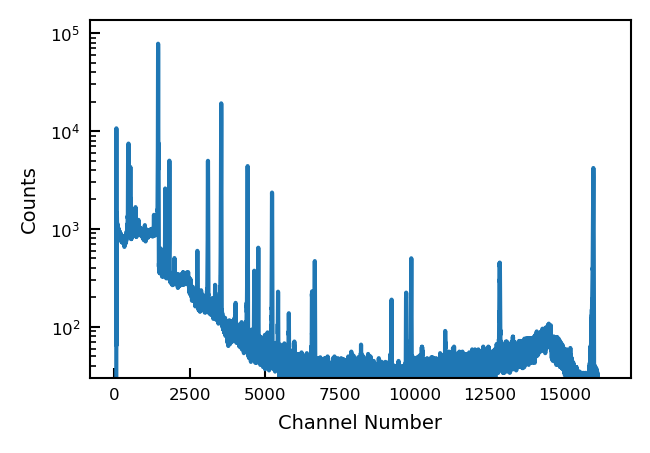

In [9]:
plt.plot(df.channel, df.counts)
plt.yscale('log')
plt.ylim(bottom = 30)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
plt.show()

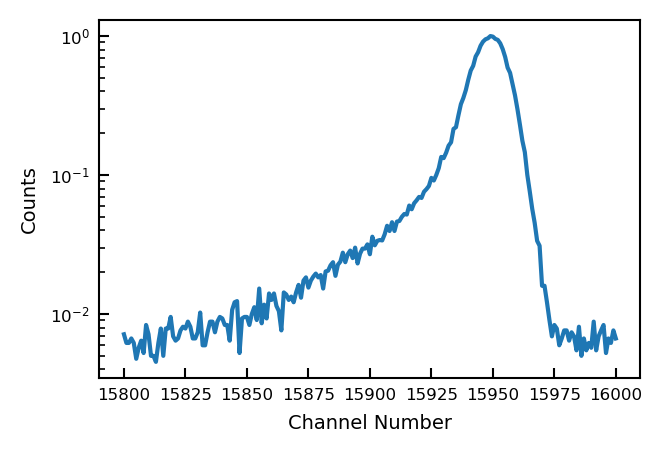

In [10]:
df1 = df.loc[15800:16000]
maxcount = df1.counts.max()

plt.plot(df1.channel, df1.counts/maxcount)
plt.yscale('log')
#plt.ylim(bottom = 30)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
plt.show()


# Fit Individual Peaks

In [11]:
def gausFunc(E, Gamma,P,sigma,C):
    gaus = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + C
    return gaus

#def tailFunc(E, Gamma,P,sigma,beta,C):
#    tail = Gamma * np.exp((E-P)/beta)*special.erfc(((E-P)/beta)+(sigma/(np.sqrt(2)*beta))) + C
#    return tail

from scipy.stats import crystalball
def crystalballFunc(E, Gamma,P,sigma,alpha,n,C):
    ## https://scipy.github.io/devdocs/generated/scipy.stats.crystalball.html
    crys = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + C
    return crys

def stepFunc(E, S,P,sigma,C):
    step = S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return step

def linFunc(E, m,q):
    lin = m*E+q
    return lin

def gausStepFunc(E, Gamma,S,P,sigma,C):
    gausStep = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return gausStep

def fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q
    return res

In [12]:
df_calibration = pd.DataFrame(data={'name': [], 'e_lit': [], 'e_err_lit': [], 
                                    'peak_position': [], 'peak_position_unc': [], 
                                    'peak_width': [], 'peak_width_unc': [], 
                                    'chi2_dof': [], 'channel_max': []})

## Pb238

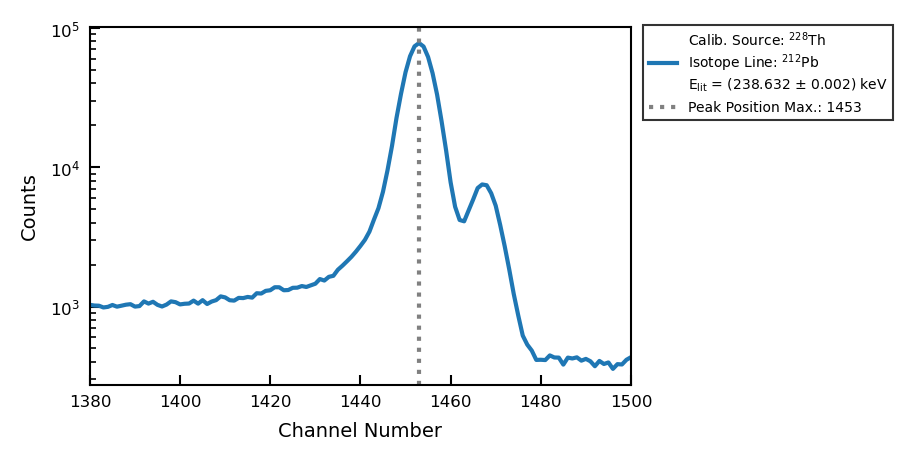

In [13]:
name = 'Pb238'
isotope = '$^{212}$Pb'
e_lit = 238.632 #keV
e_err_lit = 0.002 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1380
upper_channel = 1500
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [14]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 5. ##random guess, seems to work
guess_n = 5. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,0.1]
limits_q = [-np.inf,+np.inf]

In [15]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

[ 6.41520821e+05  1.45301330e+03  3.24962160e+00  1.83384363e+00
  1.67735017e+00  1.70173051e+02 -1.00000000e-01  7.45250957e+02]


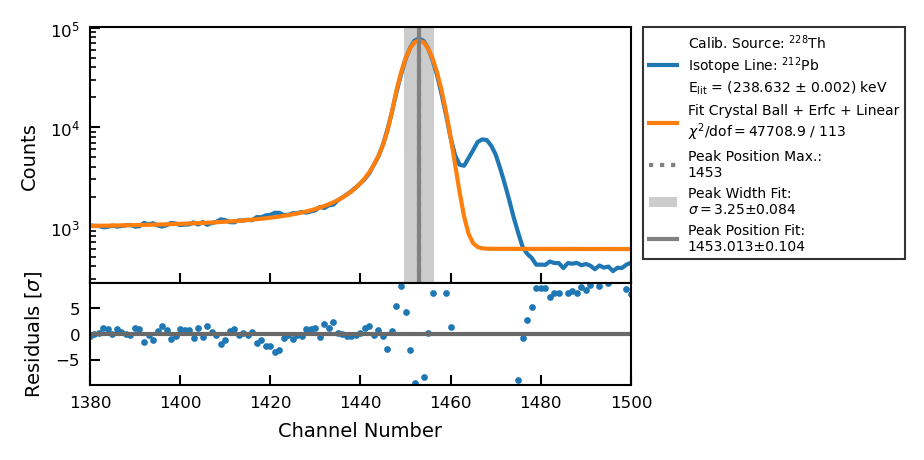

In [16]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
#yticks[-1].label1.set_visible(False)
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

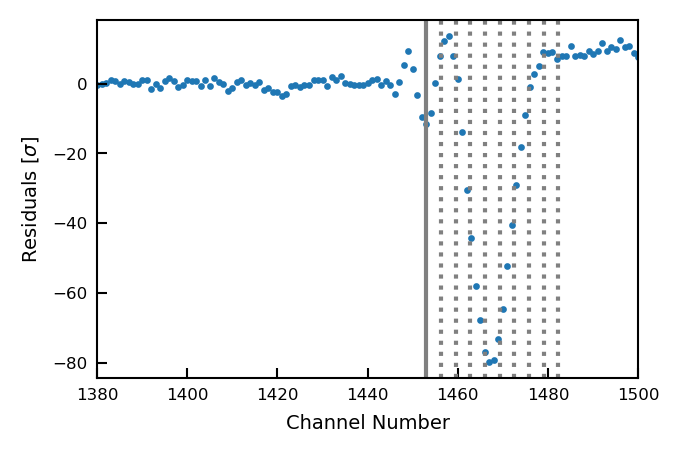

In [17]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
for i in range(1,10):
    plt.axvline(peak_position+i*peak_width, linestyle='dotted', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

**Comment:** little peak from Ra-224 at ~240keV above Pb-212 peak affects the fit -> add additional Gaussian with clever fit constraints.

In [18]:
def fitFunc238(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [19]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,_,_,_ = popt
#guess_sigma = popt[2]

guess_P2 = popt[1] + 5*popt[2]
guess_Gamma2 = (val_max - high_med)/10
guess_sigma2 = popt[2]

limits_P2 = [popt[1] + 3*popt[2], min(popt[1]+7*popt[2], upper_channel)]
limits_Gamma2 = [1, (val_max - high_med)/2]
limits_sigma2 = [0.5, min(2*popt[2], 100,(upper_channel-lower_channel)/2)]

In [20]:
## Total Fit
popt, pcov = curve_fit(fitFunc238, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[6.32224054e+05 1.45299067e+03 3.14150956e+00 1.75146248e+00
 1.94094345e+00 2.90988263e+02 1.00000000e-01 2.60243725e+02
 6.96683578e+03 1.46707107e+03 3.38109414e+00]
Appending data for Pb238 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/85123737.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


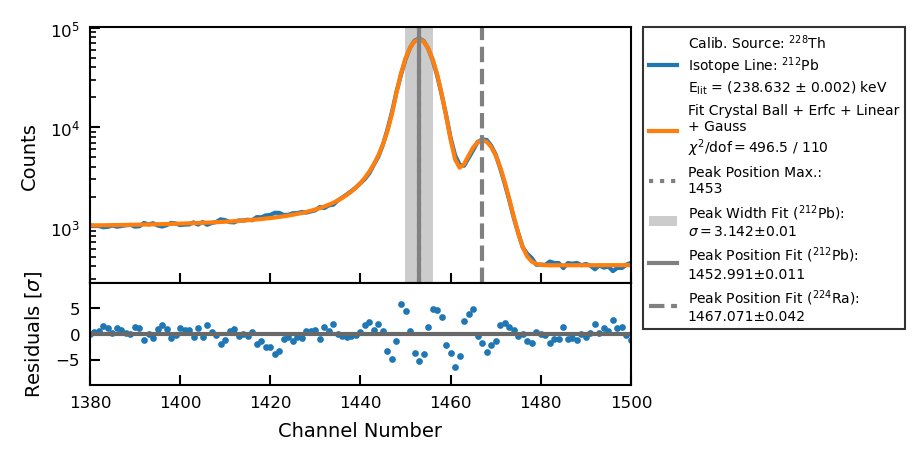

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,Pb238,238.632,0.002,1452.990668,0.010876,3.14151,0.009761,4.513262,1453.0


In [21]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc238(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{224}$Ra):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()
df_calibration

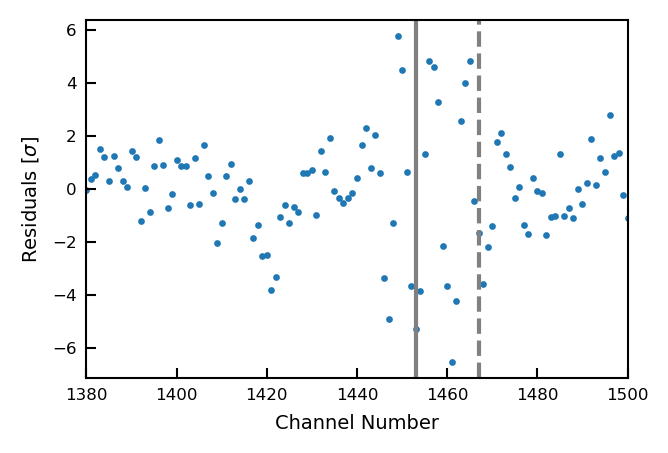

In [22]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
plt.axvline(peak2_position, linestyle='dashed', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

## Tl 277

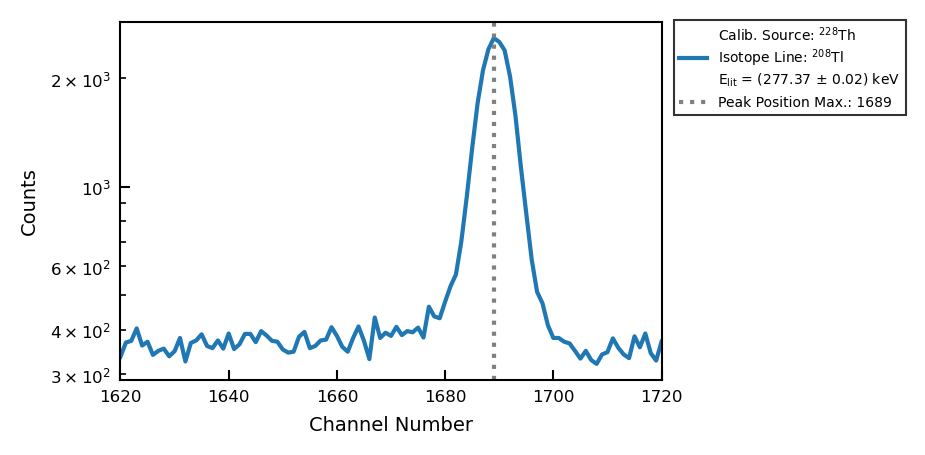

In [23]:
name = 'Tl277'
isotope = '$^{208}$Tl'
e_lit = 277.37 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1620
upper_channel = 1720
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [24]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 5. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,0]
limits_q = [-np.inf,+np.inf]

In [25]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 2.04250799e+04  1.68935780e+03  3.26748362e+00  1.89741798e+00
  1.34765803e+00  1.64856772e+00 -1.01752573e-11  3.54651932e+02]
Appending data for Tl277 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


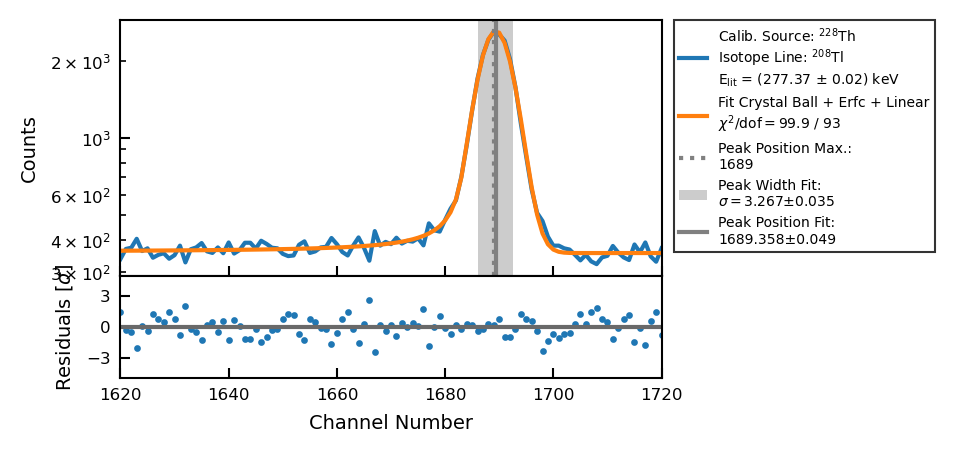

In [26]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Pb 300

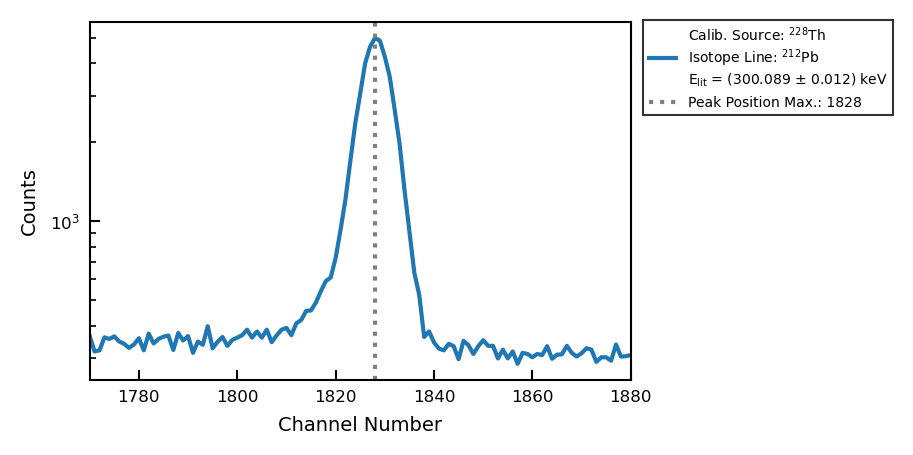

In [27]:
name = 'Pb300'
isotope = '$^{212}$Pb'
e_lit = 300.089 #keV
e_err_lit = 0.012 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1770
upper_channel = 1880
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [28]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 5. ##random guess, seems to work
guess_n = 5. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [29]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)


[ 3.83630544e+04  1.82823476e+03  3.42094033e+00  4.57168645e+02
  4.60144134e+02  5.77783685e+01  9.69481897e-01 -1.48591499e+03]


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


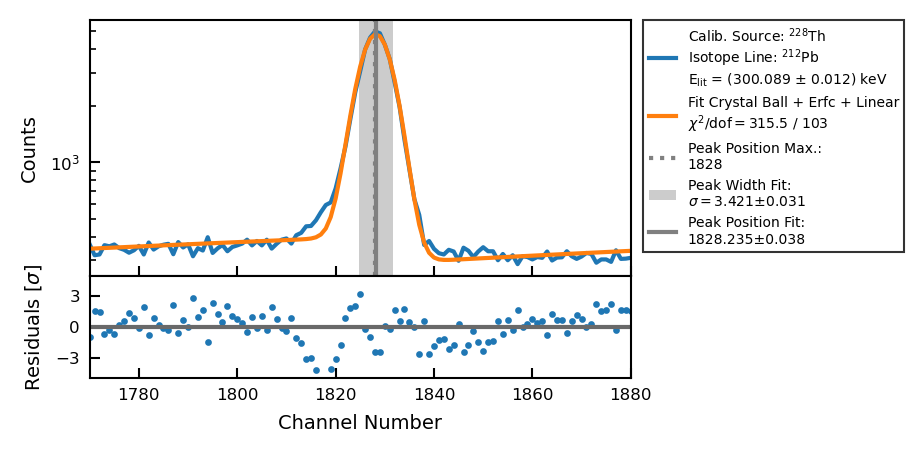

In [30]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

In [31]:
def fitFunc238(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [32]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,_,_,_ = popt
#guess_sigma = popt[2]

guess_P2 = popt[1] + 5*popt[2]
guess_Gamma2 = (val_max - high_med)/10
guess_sigma2 = popt[2]

limits_P2 = [popt[1] + 3*popt[2], min(popt[1]+7*popt[2], upper_channel)]
limits_Gamma2 = [1, (val_max - high_med)/2]
limits_sigma2 = [0.5, min(2*popt[2], 100,(upper_channel-lower_channel)/2)]

In [33]:
## Total Fit
popt, pcov = curve_fit(fitFunc238, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 4.00938131e+04  1.82822996e+03  3.31915110e+00  1.59104996e+00
  2.83125245e+00  1.28255649e+01 -7.69029563e-02  4.54770227e+02
  2.25911957e+01  1.84113980e+03  6.84188067e+00]
Appending data for Pb300 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/85123737.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


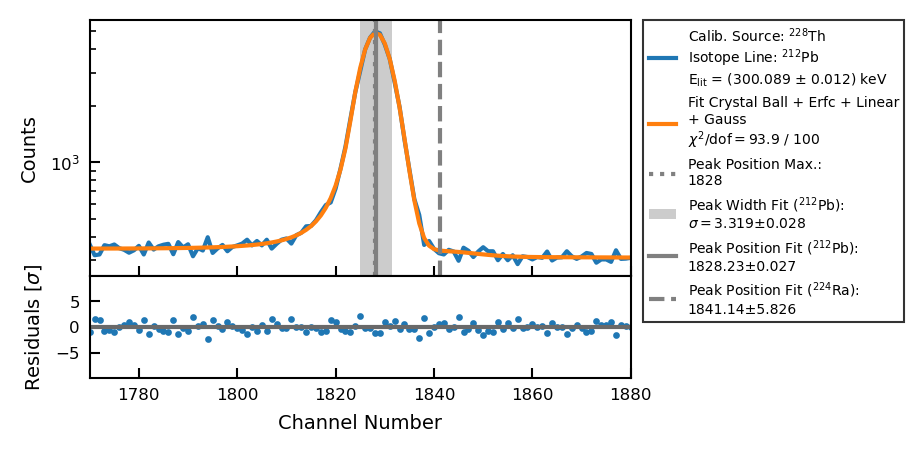

In [34]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc238(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{224}$Ra):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

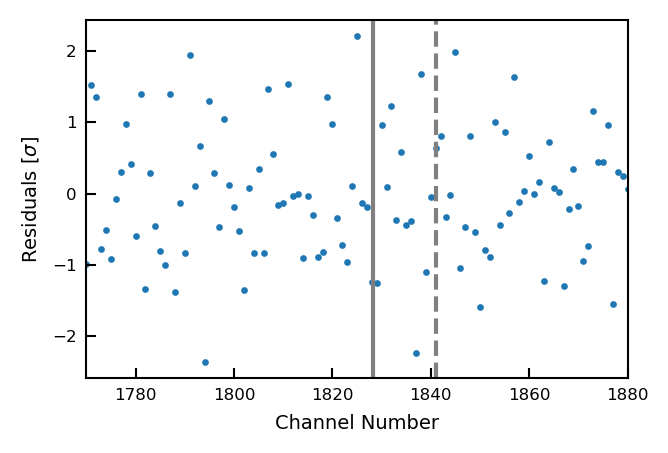

In [35]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
plt.axvline(peak2_position, linestyle='dashed', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

## Tl 583

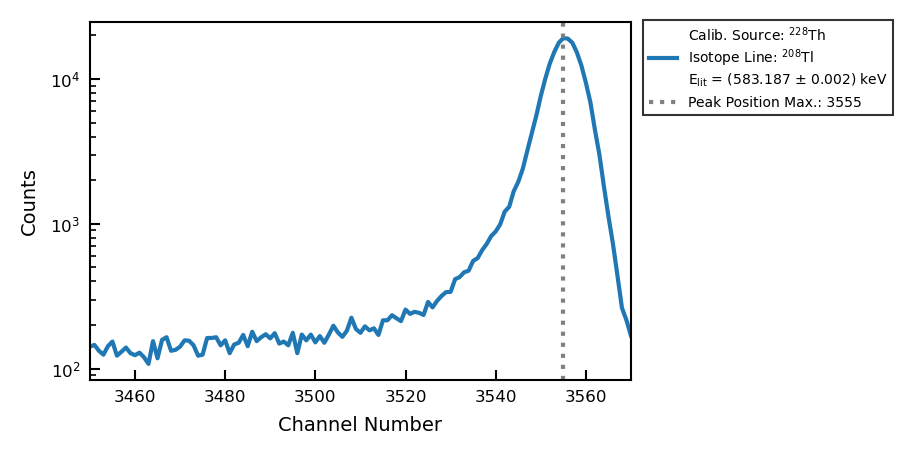

In [36]:
name = 'Tl583'
isotope = '$^{208}$Tl'
e_lit = 583.187 #keV
e_err_lit = 0.002 #keV

#######################
## Adjust these values if necessary:
lower_channel = 3450
upper_channel = 3570
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [37]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 5 ##random guess, seems to work
guess_n = 5. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [38]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 2.00650460e+05  3.55539414e+03  3.90521992e+00  1.35375113e+00
  2.98897339e+00 -5.54461765e+00  2.92847175e-01 -8.71229812e+02]
Appending data for Tl583 to df_calibration.


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


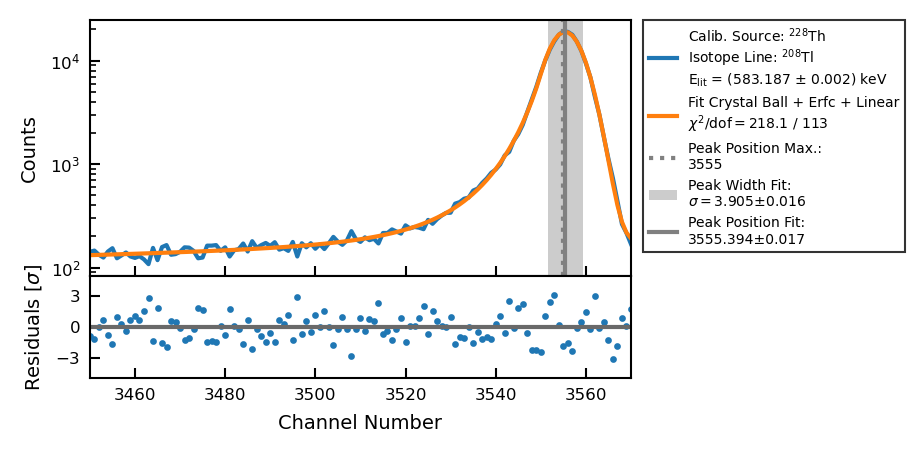

In [39]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 727

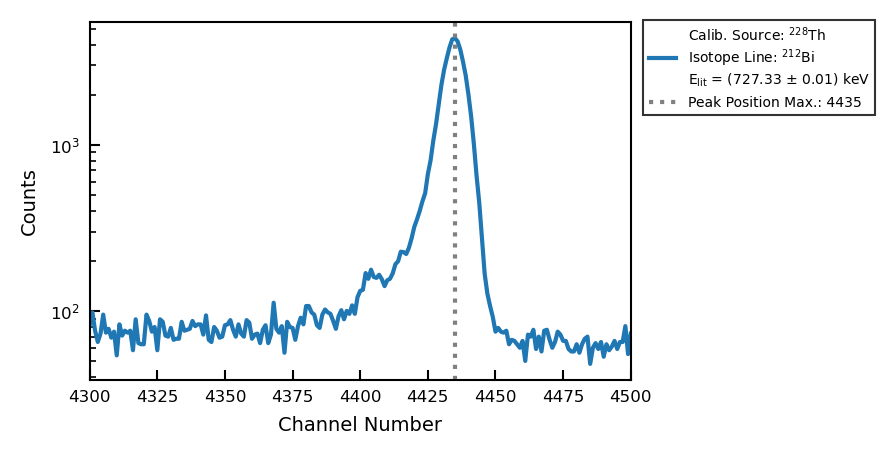

In [40]:
name = 'Bi727'
isotope = '$^{212}$Bi'
e_lit = 727.33 #keV
e_err_lit = 0.01 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4300
upper_channel = 4500
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [41]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit 
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel) 
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [42]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 5.16029603e+04  4.43474647e+03  4.19301371e+00  1.41990144e+00
  1.75875232e+00 -7.55636777e+00 -1.16322582e-01  5.84980727e+02]
Appending data for Bi727 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


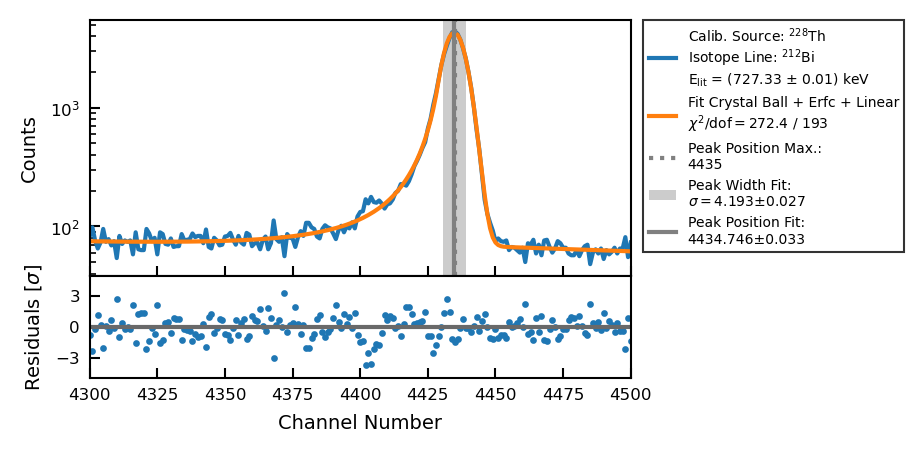

In [43]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

**Comment:** little peak from Tl-208 at ~727keV below Bi-212 peak might slightly affect the fit (deviation maximum position and position from fit > 0.5 bins) -> add additional Gaussian with clever fit constraints.

In [44]:
def fitFunc727(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [45]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q = popt

guess_P2 = popt[1] - 10*popt[2]
guess_Gamma2 = (val_max - (low_med+high_med)/2)/100
guess_sigma2 = popt[2]

limits_P2 = [(lower_channel+popt[1])/2, popt[1] - 2*popt[2]]
limits_Gamma2 = [0, (val_max - (low_med+high_med)/2)/10]
limits_sigma2 = [0.5, min(10*popt[2], 100,(upper_channel-lower_channel)/2)]

In [46]:
## Total Fit
popt, pcov = curve_fit(fitFunc727, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc727(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc727(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

[ 4.97660937e+04  4.43476643e+03  4.18327179e+00  1.36121130e+00
  2.25391603e+00 -1.76956636e+00 -7.03238501e-02  3.79186229e+02
  5.10875766e+01  4.40359065e+03  2.65321521e+00]


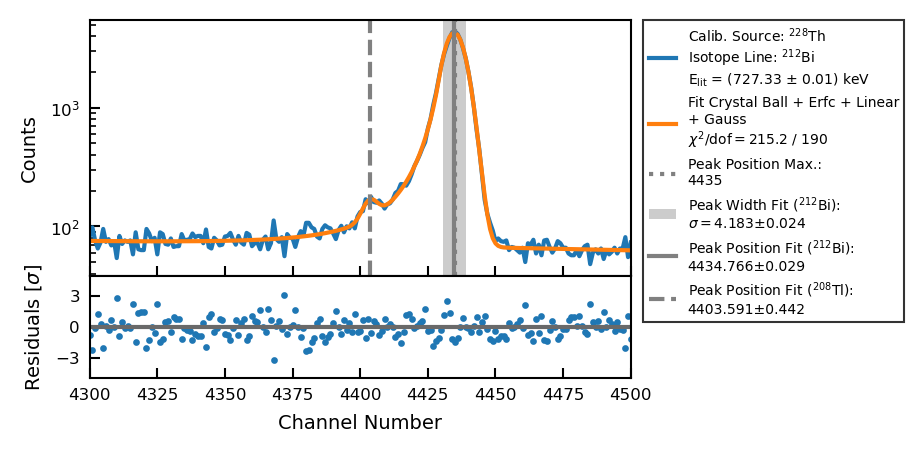

In [47]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc727(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{208}$Tl):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

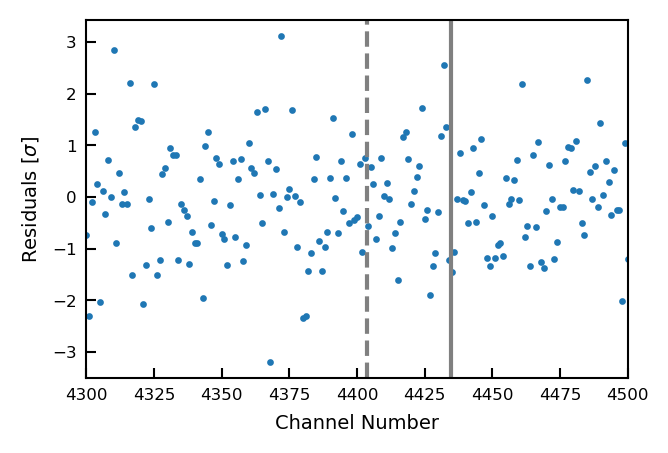

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,Pb238,238.632,0.002,1452.990668,0.010876,3.141510,0.009761,4.513262,1453.0
1,Tl277,277.370,0.020,1689.357801,0.049038,3.267484,0.034729,1.073887,1689.0
2,Pb300,300.089,0.012,1828.229959,0.026557,3.319151,0.027810,0.938595,1828.0
3,Tl583,583.187,0.002,3555.394139,0.017392,3.905220,0.015753,1.929981,3555.0
4,Bi727,727.330,0.010,4434.746474,0.032532,4.193014,0.026755,1.411522,4435.0


In [48]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
plt.axvline(peak2_position, linestyle='dashed', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()
df_calibration

## Bi 763

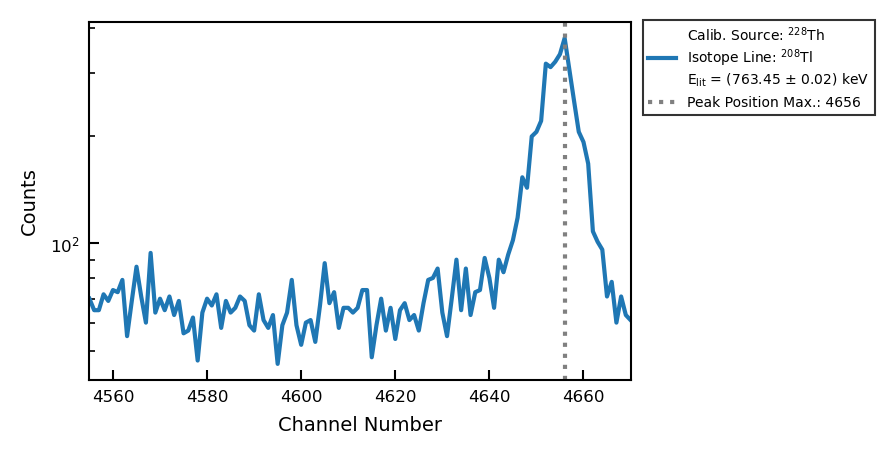

In [49]:
name = 'Bi763'
isotope = '$^{208}$Tl'
e_lit = 763.45 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4555
upper_channel = 4670
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [50]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0# (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.4, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 100]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,+0.1] #[-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [51]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 3.33036684e+03  4.65466461e+03  4.09263244e+00  1.08787784e+00
  3.33187993e+00 -3.99281651e+00 -1.00000000e-01  5.30706626e+02]
Appending data for Bi763 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


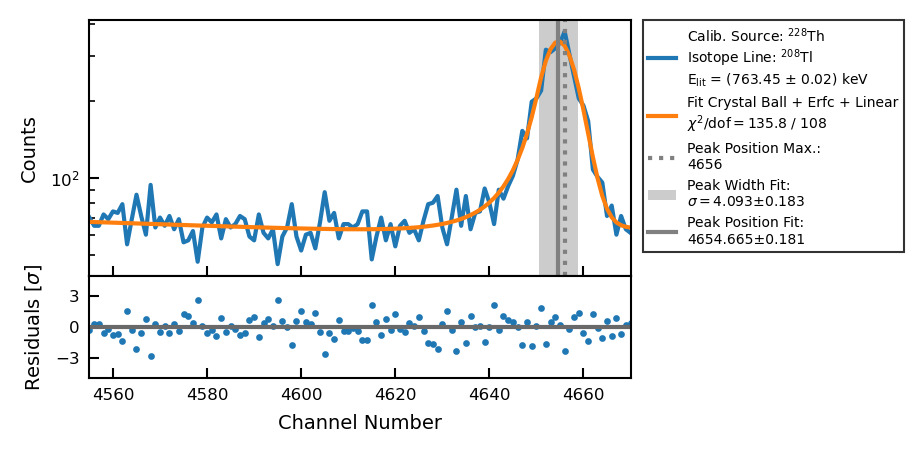

In [52]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 785

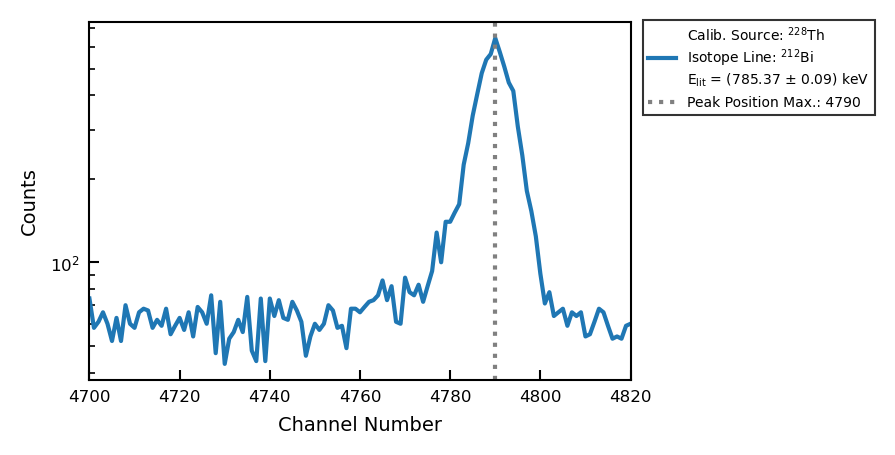

In [53]:
name = 'Bi785'
isotope = '$^{212}$Bi'
e_lit = 785.37 #keV
e_err_lit = 0.09 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4700
upper_channel = 4820
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [54]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 5. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.05, 100]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [55]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 6.45664327e+03  4.78982593e+03  4.27084574e+00  1.30938388e+00
  2.31296089e+00 -3.75000000e+00 -7.02004515e-02  3.97643973e+02]
Appending data for Bi785 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


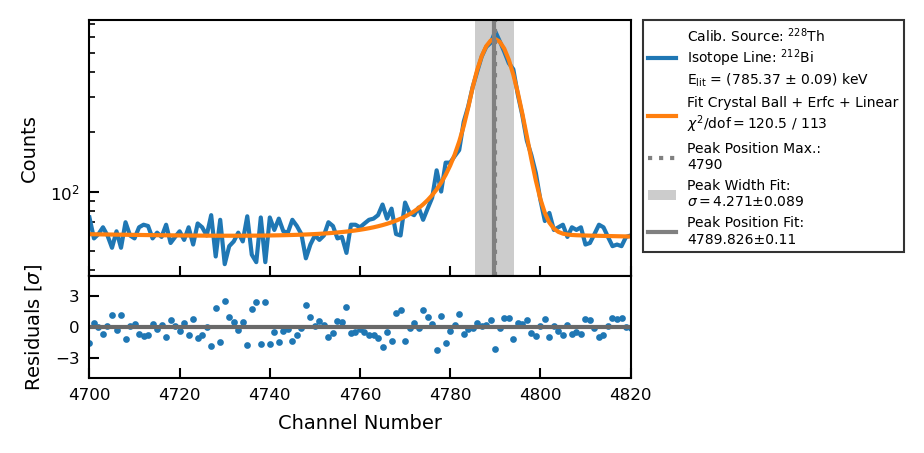

In [56]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 860

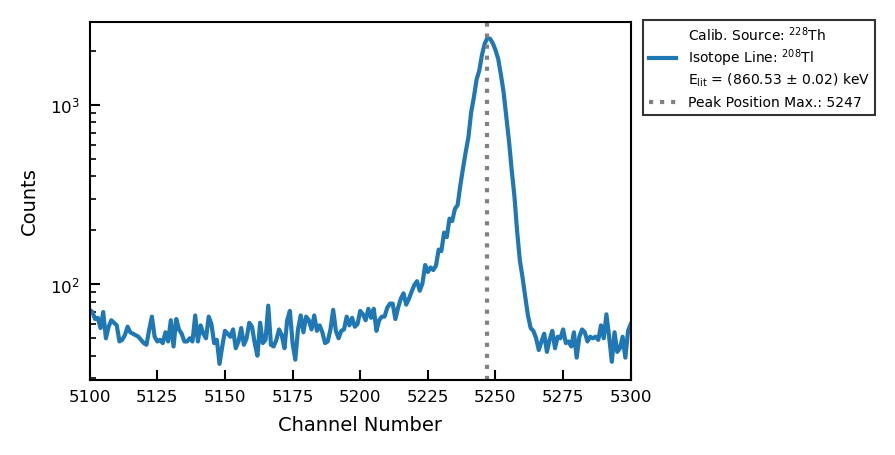

In [57]:
name = 'Tl860'
isotope = '$^{208}$Tl'
e_lit = 860.53 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 5100
upper_channel = 5300
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [58]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [59]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 2.92243278e+04  5.24761057e+03  4.48617867e+00  1.34104271e+00
  2.06453922e+00 -6.38326108e+00 -9.28689962e-02  5.39709795e+02]
Appending data for Tl860 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


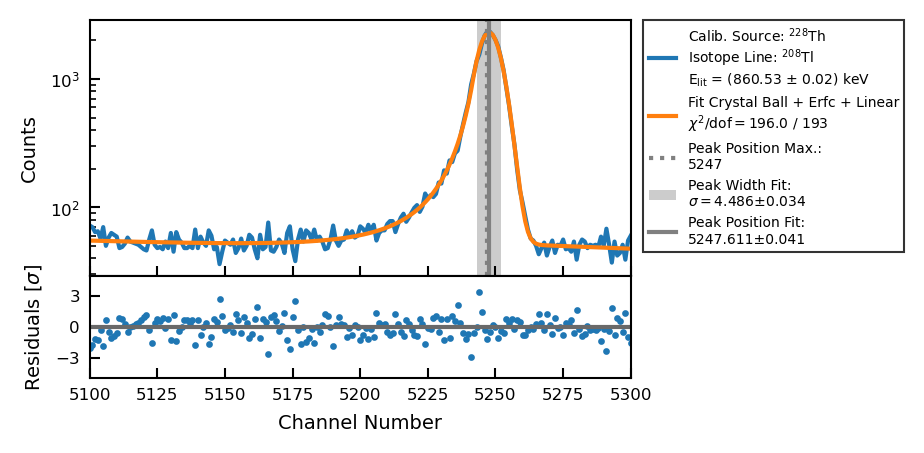

In [60]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 1620

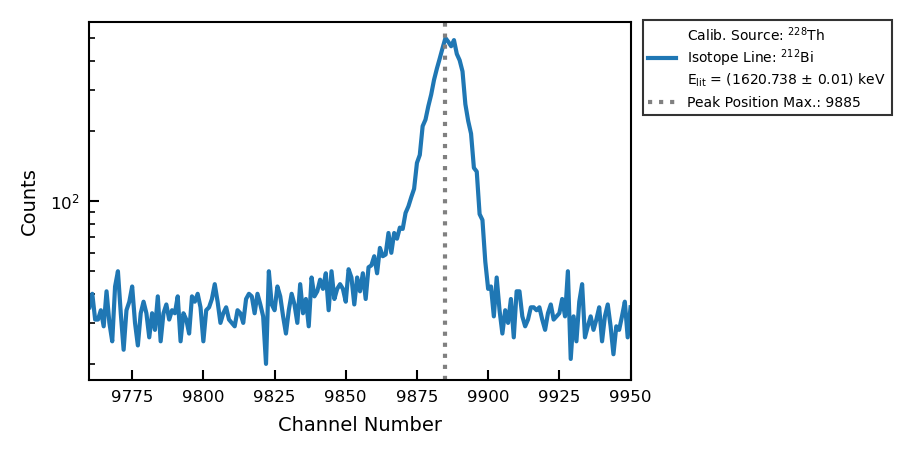

In [61]:
name = 'Bi1620'
isotope = '$^{212}$Bi'
e_lit = 1620.738 #keV
e_err_lit = 0.010 #keV

#######################
## Adjust these values if necessary:
lower_channel = 9760
upper_channel = 9950
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [62]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.05, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

'''## Improve guess/limits parameter sigma from Gauss+Step fit
try:
    popt, pcov = curve_fit(gausStepFunc, df_sel_peak.channel, df_sel_peak.counts, 
                           p0=[guess_Gamma, guess_S, guess_P, guess_sigma, (low_med+high_med)/2], 
                           bounds=((limits_Gamma[0], limits_S[0], limits_P[0], limits_sigma[0], 1.1*val_min-0.1*val_max),
                                   (limits_Gamma[1], limits_S[1], limits_P[1], limits_sigma[1], val_max)), 
                           sigma=df_sel_peak.counts_err, maxfev=10000)
    _,_,_,guess_sigma,_ = popt
    limits_sigma[1] = min(5*guess_sigma, limits_sigma[1])
except:
    print('Warning: gausStepFunc failed!')''';

In [63]:
'''df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
plt.plot(df_sel_peak.channel, gausStepFunc(df_sel_peak.channel, *popt), 
         label='Fit Gauss + Erfc')

plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
plt.axvspan(popt[2]-popt[3], popt[2]+popt[3], alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(popt[3],3))+'±'+str(round(np.sqrt(pcov[3,3]),3)))
plt.axvline(popt[2], linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(popt[2],3))+'±'+str(round(np.sqrt(pcov[2,2]),3)))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()''';

In [64]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
'''if np.abs(peak_width-guess_sigma)/peak_width > 0.2:
    print('Warning: Final peak width deviates from gausStepFunc peak width by '+str(round(100*np.abs(peak_width-guess_sigma)/peak_width,1))+' %')'''
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)
if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 6.57750172e+03  9.88551584e+03  6.02734461e+00  8.47871590e+02
  9.87413640e+01  5.00000000e+00  6.01025845e-02 -5.64061932e+02]
Appending data for Bi1620 to df_calibration.


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/2481559078.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


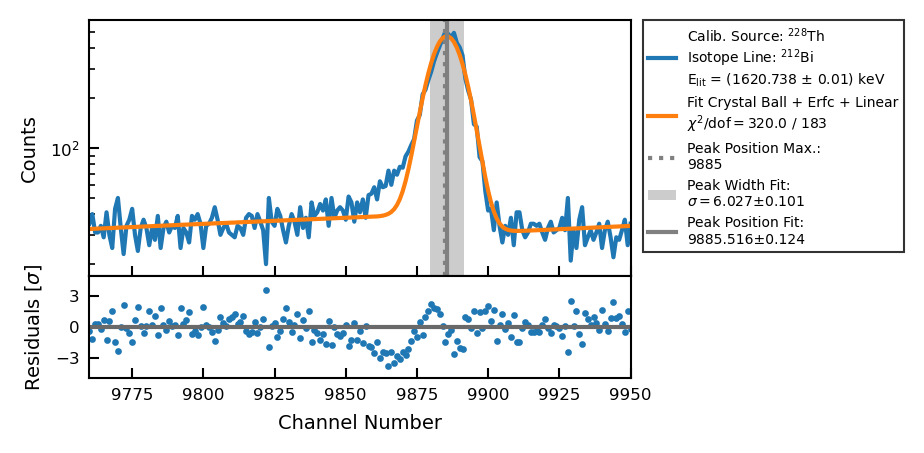

In [65]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 2614

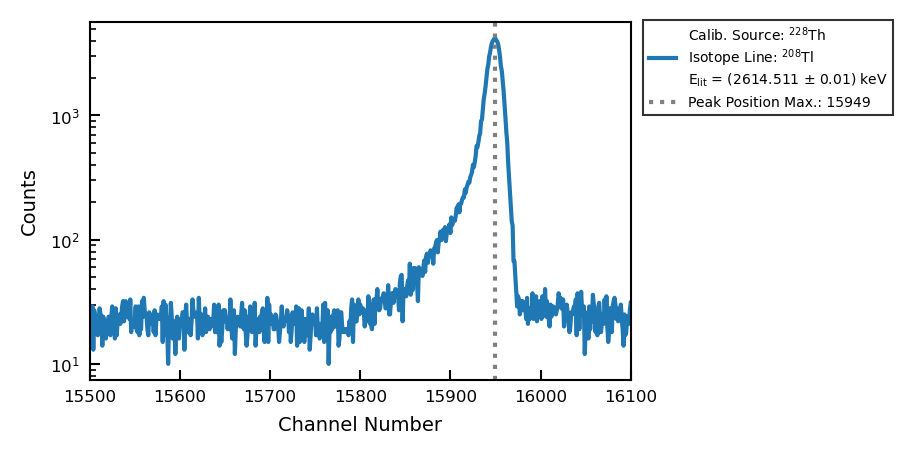

In [66]:
name = 'Tl2614'
isotope = '$^{208}$Tl'
e_lit = 2614.511 #keV
e_err_lit = 0.010 #keV

#######################
## Adjust these values if necessary:
lower_channel = 15500
upper_channel = 16100
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [67]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 10. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.05, 1000]
limits_n = [0.01, 1000]
limits_S = [-2*guess_S-0.01,2*guess_S+0.01]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [68]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 8.79179403e+04  1.59489708e+04  7.06703176e+00  1.13484582e+00
  2.41383937e+00 -1.00000000e-02  9.31447025e-03 -1.26276670e+02]
Appending data for Tl2614 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_8208/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


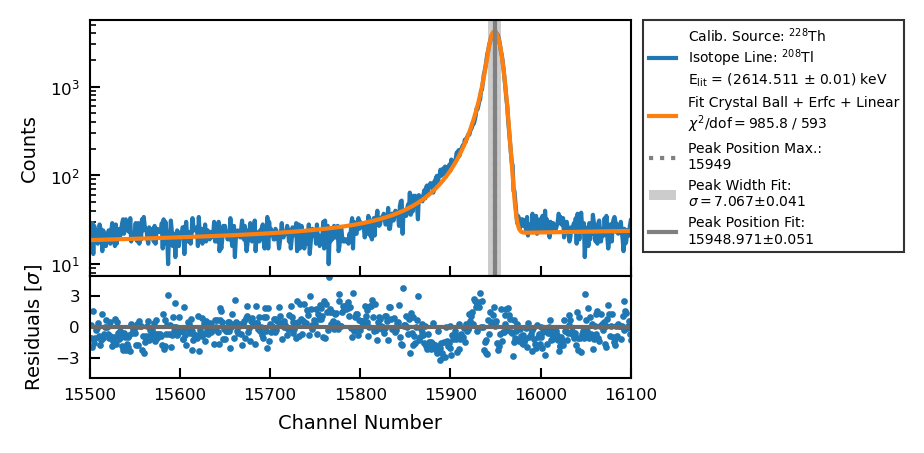

In [69]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

# Quality Checks

In [70]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,Pb238,238.632,0.002,1452.990668,0.010876,3.141510,0.009761,4.513262,1453.0
1,Tl277,277.370,0.020,1689.357801,0.049038,3.267484,0.034729,1.073887,1689.0
2,Pb300,300.089,0.012,1828.229959,0.026557,3.319151,0.027810,0.938595,1828.0
3,Tl583,583.187,0.002,3555.394139,0.017392,3.905220,0.015753,1.929981,3555.0
4,Bi727,727.330,0.010,4434.746474,0.032532,4.193014,0.026755,1.411522,4435.0
5,Bi763,763.450,0.020,4654.664610,0.180676,4.092632,0.182971,1.257695,4656.0
6,Bi785,785.370,0.090,4789.825934,0.110004,4.270846,0.089473,1.066725,4790.0
7,Tl860,860.530,0.020,5247.610567,0.041176,4.486179,0.034345,1.015292,5247.0
8,Bi1620,1620.738,0.010,9885.515835,0.123508,6.027345,0.101092,1.748656,9885.0
9,Tl2614,2614.511,0.010,15948.970765,0.050616,7.067032,0.040514,1.662441,15949.0


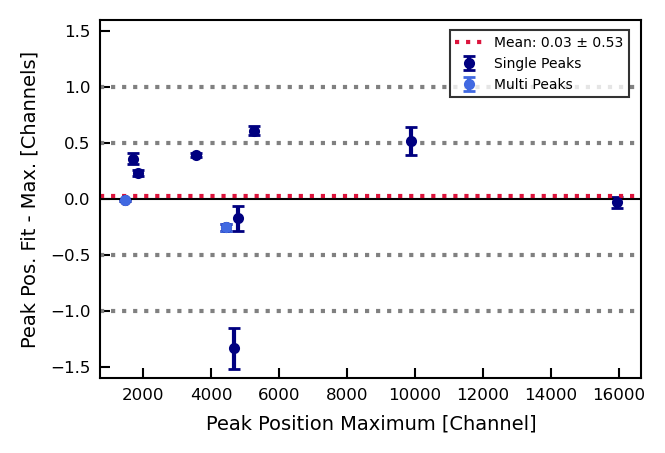

     name     e_lit  e_err_lit  peak_position  peak_position_unc  peak_width  \
0   Pb238   238.632      0.002    1452.990668           0.010876    3.141510   
1   Tl277   277.370      0.020    1689.357801           0.049038    3.267484   
2   Pb300   300.089      0.012    1828.229959           0.026557    3.319151   
3   Tl583   583.187      0.002    3555.394139           0.017392    3.905220   
4   Bi727   727.330      0.010    4434.746474           0.032532    4.193014   
5   Bi763   763.450      0.020    4654.664610           0.180676    4.092632   
6   Bi785   785.370      0.090    4789.825934           0.110004    4.270846   
7   Tl860   860.530      0.020    5247.610567           0.041176    4.486179   
8  Bi1620  1620.738      0.010    9885.515835           0.123508    6.027345   
9  Tl2614  2614.511      0.010   15948.970765           0.050616    7.067032   

   peak_width_unc  chi2_dof  channel_max  
0        0.009761  4.513262       1453.0  
1        0.034729  1.073887      

In [71]:
plt.errorbar(df_calibration.channel_max, df_calibration.peak_position-df_calibration.channel_max, 
             yerr = df_calibration.peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'navy', label = 'Single Peaks')
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 df_calibration[df_calibration.name == 'Bi727'].peak_position-df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Bi727'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', 
                 label = 'Multi Peaks')
except:
    pass
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 df_calibration[df_calibration.name == 'Pb238'].peak_position-df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Pb238'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', )
except:
    pass
plt.axhline(y=0, linestyle='-', color = 'k', linewidth = 0.75)
plt.axhline(y=+0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=-0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=+1.0, linestyle='dotted', color = 'gray')
plt.axhline(y=-1.0, linestyle='dotted', color = 'gray')
val_mean_diff = np.mean(df_calibration.peak_position-df_calibration.channel_max)
val_std_diff = np.std(df_calibration.peak_position-df_calibration.channel_max)
plt.axhline(y=val_mean_diff, 
            linestyle='dotted', color = 'crimson', label = 'Mean: '+str(round(val_mean_diff,2))+' ± '+str(round(val_std_diff,2)))
plt.xlabel('Peak Position Maximum [Channel]')
plt.ylabel('Peak Pos. Fit - Max. [Channels]')
val_lim = 1.2*np.max(np.abs(df_calibration.peak_position-df_calibration.channel_max))
plt.ylim(-val_lim, +val_lim)

legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_deviation_lines_max_fit.png', bbox_inches='tight')
plt.show()
print(df_calibration)

In [72]:
thr = 5
outlier_check = np.abs(df_calibration.peak_position-df_calibration.channel_max)>thr
if np.any(outlier_check):
    print('Warning: For the following peaks, the peak max. and fit positions differ by more than 1 Channel and are hence removed from the following analysis: '+str(df_calibration[outlier_check].name.tolist()))
    #df_calibration = df_calibration.drop(df_calibration[outlier_check].index.values)
else:
    print('For all peaks, the peak max. and fit positions differ by less than '+str(thr)+' Channel. We hence keep them all for the following analysis.')
    print(df_calibration)

For all peaks, the peak max. and fit positions differ by less than 5 Channel. We hence keep them all for the following analysis.
     name     e_lit  e_err_lit  peak_position  peak_position_unc  peak_width  \
0   Pb238   238.632      0.002    1452.990668           0.010876    3.141510   
1   Tl277   277.370      0.020    1689.357801           0.049038    3.267484   
2   Pb300   300.089      0.012    1828.229959           0.026557    3.319151   
3   Tl583   583.187      0.002    3555.394139           0.017392    3.905220   
4   Bi727   727.330      0.010    4434.746474           0.032532    4.193014   
5   Bi763   763.450      0.020    4654.664610           0.180676    4.092632   
6   Bi785   785.370      0.090    4789.825934           0.110004    4.270846   
7   Tl860   860.530      0.020    5247.610567           0.041176    4.486179   
8  Bi1620  1620.738      0.010    9885.515835           0.123508    6.027345   
9  Tl2614  2614.511      0.010   15948.970765           0.050616    7.0

# Calibration

## Linear fit

In [73]:
popt, pcov = curve_fit(linFunc, df_calibration.peak_position, df_calibration.e_lit, 
                       p0=[np.median(df_calibration.e_lit/df_calibration.peak_position), 0], 
                       bounds=((0, -np.inf),
                               (+np.inf, +np.inf)), 
                       sigma=df_calibration.peak_width, maxfev=10000)

cal_CE_a = popt[0]
print(cal_CE_a)
cal_CE_a_err = np.sqrt(pcov[0, 0])
print(cal_CE_a_err)
cal_CE_b = popt[1]
print('')
print(cal_CE_b)
cal_CE_b_err = np.sqrt(pcov[1, 1])
print(cal_CE_b_err)
cal_CE_cov_ab = pcov[0, 1]
cal_CE = (cal_CE_a, cal_CE_b)

cal_EC_a = 1/cal_CE_a
cal_EC_b = -cal_CE_b/cal_CE_a
cal_EC = (cal_EC_a, cal_EC_b)

with open(filename_suffix_save+'_calibration_parameters.txt', 'w') as writer:
    writer.write("cal_CE_a"+"\n")
    writer.write(str(cal_CE_a)+"\n")
    writer.write("cal_CE_a_err"+"\n")
    writer.write(str(cal_CE_a_err)+"\n")
    writer.write("cal_CE_b"+"\n")
    writer.write(str(cal_CE_b)+"\n")
    writer.write("cal_CE_b_err"+"\n")
    writer.write(str(cal_CE_b_err)+"\n")
    writer.write("cal_CE_cov_ab"+"\n")
    writer.write(str(cal_CE_cov_ab)+"\n")

print(df_calibration)
df_calibration.to_csv('Th228_top_calib.txt', sep = ',')

0.16389984701772356
6.419451539984048e-06

0.46454797148251575
0.03097544724373892
     name     e_lit  e_err_lit  peak_position  peak_position_unc  peak_width  \
0   Pb238   238.632      0.002    1452.990668           0.010876    3.141510   
1   Tl277   277.370      0.020    1689.357801           0.049038    3.267484   
2   Pb300   300.089      0.012    1828.229959           0.026557    3.319151   
3   Tl583   583.187      0.002    3555.394139           0.017392    3.905220   
4   Bi727   727.330      0.010    4434.746474           0.032532    4.193014   
5   Bi763   763.450      0.020    4654.664610           0.180676    4.092632   
6   Bi785   785.370      0.090    4789.825934           0.110004    4.270846   
7   Tl860   860.530      0.020    5247.610567           0.041176    4.486179   
8  Bi1620  1620.738      0.010    9885.515835           0.123508    6.027345   
9  Tl2614  2614.511      0.010   15948.970765           0.050616    7.067032   

   peak_width_unc  chi2_dof  channel

In [74]:
reconstr_e = linFunc(df_calibration.peak_position, *cal_CE)
df_calibration['reconstr_e'] = reconstr_e
reconstr_e_err = np.sqrt(cal_CE_b_err**2 + (cal_CE_a_err*df_calibration.peak_position)**2 + 2*(df_calibration.peak_position)*cal_CE_cov_ab)
residuals_e = reconstr_e - df_calibration.e_lit
residuals_e_err = np.sqrt(reconstr_e_err**2 + (df_calibration.e_err_lit)**2)
print(residuals_e)

0   -0.022504
1   -0.019967
2    0.022159
3    0.006103
4   -0.011183
5   -0.086635
6    0.146286
7    0.017117
8   -0.038919
9   -0.012584
dtype: float64


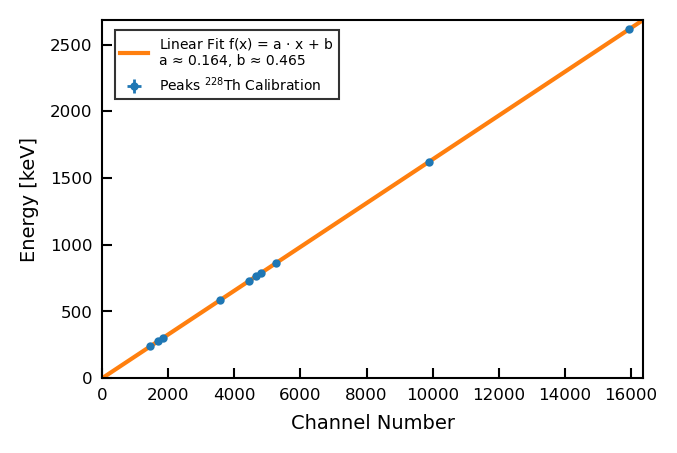

In [75]:
plt.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{228}$Th Calibration', linewidth=1)
plt.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],3))+', b ≈ '+str(round(popt[1],3)))
plt.xlabel('Channel Number')
plt.ylabel('Energy [keV]')
#plt.xscale('log'); plt.yscale('log');
plt.xlim(0, 16383)
plt.ylim(0, linFunc(16383, *popt))
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit.png', bbox_inches='tight')
plt.show()

In [76]:
chi2 = np.sum(residuals_e**2 / residuals_e_err**2)
print(chi2)
dof = len(residuals_e)-len(popt)
print(dof)

15.397886030936787
8


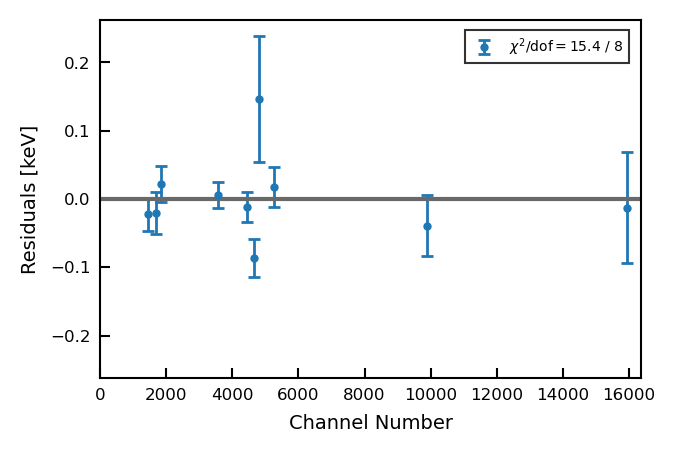

In [77]:
plt.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.xlabel('Channel Number')
plt.ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
plt.xlim(0, 16383)
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

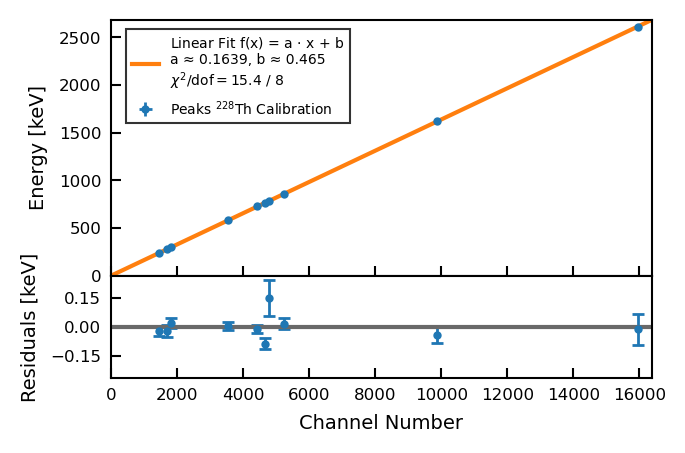

In [78]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{228}$Th Calibration', linewidth=1)
ax0.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],6))+', b ≈ '+str(round(popt[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy [keV]')
ax0.set_ylim(0, linFunc(16383, *popt))

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
plt.xlim(0, 16383)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

In [79]:
print('MCA_ch Residual MCA_ch_error Residual_error')
out = np.array([np.array(df_calibration.peak_position), np.array(residuals_e), 
                np.array(df_calibration.peak_width), np.array(residuals_e_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Residual MCA_ch_error Residual_error
1452.9906683702668 -0.02250376445084612 3.141509558576204 0.024426568584723956
1689.357801248906 -0.01996684562396922 3.267483615801284 0.030812974762850293
1828.229959425114 0.02215863447764832 3.319151096928983 0.025888128212144566
3555.394139289011 0.006103488662347445 3.905219921789919 0.019337025549112968
4434.746474052303 -0.011183368956153572 4.193013714145492 0.02201840378921115
4654.664610164821 -0.08663450369147085 4.092632440409798 0.02825767489083502
4789.8259335575285 0.14628572308629373 4.270845735485948 0.09224361981452635
5247.610566902027 0.017117095314347353 4.486178674626028 0.029244812355038365
9885.515835437665 -0.0389189090005857 6.027344607841198 0.04471010844879647
15948.970765308659 -0.012583504282702052 7.0670317574363155 0.08099659721947285


In [81]:
print('Energy Residual Energy_error Residual_error')
out = np.array([np.array(df_calibration.e_lit), np.array(-cal_EC_a*residuals_e), 
                np.array(df_calibration.e_err_lit), np.array(cal_EC_a*residuals_e_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

Energy Residual Energy_error Residual_error
238.632 0.13730192468338692 0.002 0.14903350447961403
277.37 0.12182345491640438 0.02 0.18799880124060325
300.089 -0.13519618767705233 0.012 0.15795089918140748
583.187 -0.037239135810098925 0.002 0.11798074190406004
727.33 0.06823294322504304 0.01 0.13434060000574716
763.45 0.528581967999656 0.02 0.17240818344253447
785.37 -0.8925311752760507 0.09 0.5628047950804459
860.53 -0.10443631050184184 0.02 0.17843099238448912
1620.738 0.23745543213580392 0.01 0.27278920183471356
2614.511 0.07677557064065664 0.01 0.4941834827381758


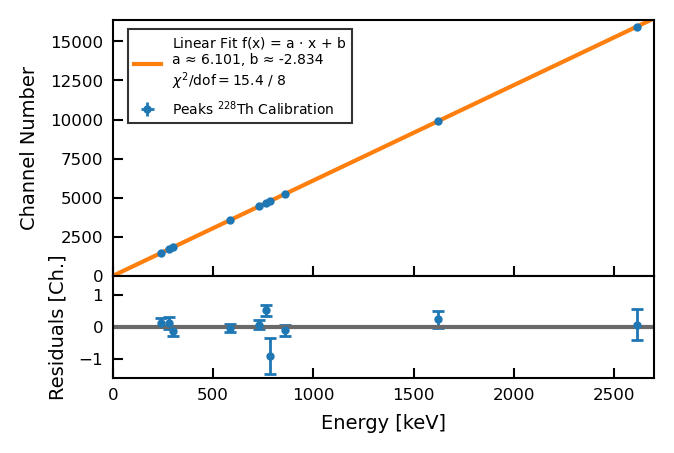

0   -0.137302
1   -0.121823
2    0.135196
3    0.037239
4   -0.068233
5   -0.528582
6    0.892531
7    0.104436
8   -0.237455
9   -0.076776
dtype: float64 0    0.149034
1    0.187999
2    0.157951
3    0.117981
4    0.134341
5    0.172408
6    0.562805
7    0.178431
8    0.272789
9    0.494183
dtype: float64


,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max,reconstr_e
0,Pb238,238.632,0.002,1452.990668,0.010876,3.141510,0.009761,4.513262,1453.0,238.609496
1,Tl277,277.370,0.020,1689.357801,0.049038,3.267484,0.034729,1.073887,1689.0,277.350033
2,Pb300,300.089,0.012,1828.229959,0.026557,3.319151,0.027810,0.938595,1828.0,300.111159
3,Tl583,583.187,0.002,3555.394139,0.017392,3.905220,0.015753,1.929981,3555.0,583.193103
4,Bi727,727.330,0.010,4434.746474,0.032532,4.193014,0.026755,1.411522,4435.0,727.318817
5,Bi763,763.450,0.020,4654.664610,0.180676,4.092632,0.182971,1.257695,4656.0,763.363365
6,Bi785,785.370,0.090,4789.825934,0.110004,4.270846,0.089473,1.066725,4790.0,785.516286
7,Tl860,860.530,0.020,5247.610567,0.041176,4.486179,0.034345,1.015292,5247.0,860.547117
8,Bi1620,1620.738,0.010,9885.515835,0.123508,6.027345,0.101092,1.748656,9885.0,1620.699081
9,Tl2614,2614.511,0.010,15948.970765,0.050616,7.067032,0.040514,1.662441,15949.0,2614.498416


In [82]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, df_calibration.peak_position, 
             yerr = df_calibration.peak_width, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{228}$Th Calibration', linewidth=1)
ax0.plot(np.linspace(0,2700,10), linFunc(np.linspace(0,2700,10), *cal_EC), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(cal_EC[0],3))+', b ≈ '+str(round(cal_EC[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Channel Number')
ax0.set_ylim(0, 16383)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, -cal_EC_a*residuals_e, yerr = cal_EC_a*residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(-cal_EC_a*residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Residuals [Ch.]')
val_lim = max(np.abs(1.1*np.max(cal_EC_a*(residuals_e+residuals_e_err))), np.abs(1.1*np.min(cal_EC_a*(residuals_e-residuals_e_err))))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-1, 1.1, step=1))
plt.xlim(0, 2700)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_inverse_residuals.png', bbox_inches='tight')
plt.show()
print(cal_EC_a*residuals_e, cal_EC_a*residuals_e_err)
df_calibration

## Spectrum

In [82]:
isotope_list = []
for i in df_calibration['name']:
    if i.find('Tl') > -1:
        isotope_list.append('$^{208}$Tl')
    elif i.find('Bi') > -1:
        isotope_list.append('$^{212}$Bi')
    elif i.find('Pb') > -1:
        isotope_list.append('$^{212}$Pb')
df_calibration['isotope'] = isotope_list

In [83]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max,reconstr_e,isotope
0,Pb238,238.632,0.002,1452.990668,0.010876,3.141510,0.009761,4.513262,1453.0,238.609496,$^{212}$Pb
1,Tl277,277.370,0.020,1689.357801,0.049038,3.267484,0.034729,1.073887,1689.0,277.350033,$^{208}$Tl
2,Pb300,300.089,0.012,1828.229959,0.026557,3.319151,0.027810,0.938595,1828.0,300.111159,$^{212}$Pb
3,Tl583,583.187,0.002,3555.394139,0.017392,3.905220,0.015753,1.929981,3555.0,583.193103,$^{208}$Tl
4,Bi727,727.330,0.010,4434.746474,0.032532,4.193014,0.026755,1.411522,4435.0,727.318817,$^{212}$Bi
5,Bi763,763.450,0.020,4654.664610,0.180676,4.092632,0.182971,1.257695,4656.0,763.363365,$^{212}$Bi
6,Bi785,785.370,0.090,4789.825934,0.110004,4.270846,0.089473,1.066725,4790.0,785.516286,$^{212}$Bi
7,Tl860,860.530,0.020,5247.610567,0.041176,4.486179,0.034345,1.015292,5247.0,860.547117,$^{208}$Tl
8,Bi1620,1620.738,0.010,9885.515835,0.123508,6.027345,0.101092,1.748656,9885.0,1620.699081,$^{212}$Bi
9,Tl2614,2614.511,0.010,15948.970765,0.050616,7.067032,0.040514,1.662441,15949.0,2614.498416,$^{208}$Tl


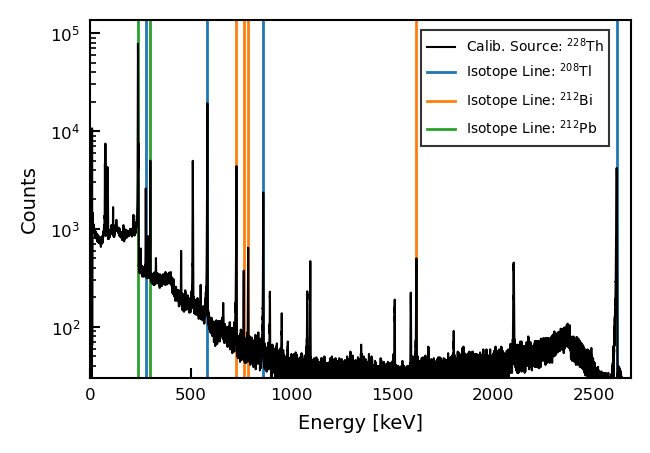

In [84]:
plt.plot(linFunc(df.channel, *cal_CE), df.counts, color = 'black', linewidth = 0.75, label = 'Calib. Source: $^{228}$Th')
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{208}$Tl'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C0', label = 'Isotope Line: $^{208}$Tl', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C0', zorder = 0, linewidth = 1)
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{212}$Bi'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C1', label = 'Isotope Line: $^{212}$Bi', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C1', zorder = 0, linewidth = 1)
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{212}$Pb'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C2', label = 'Isotope Line: $^{212}$Pb', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C2', zorder = 0, linewidth = 1)
plt.yscale('log')
plt.xlim(0,linFunc(16383, *cal_CE))
plt.ylim(bottom = 30)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(0.6,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_spectrum_lines_marked.png', bbox_inches='tight')
plt.show()

# Resolution

In [85]:
ratio_width_fitlit = cal_CE_a*df_calibration.peak_width/df_calibration.e_err_lit
ratio_width_fitlit

0    257.446468
1     26.777003
2     45.334030
3    320.032474
4     68.723431
5     33.539092
6      7.777677
7     36.764200
8     98.788086
9    115.828542
dtype: float64

In [86]:
df_calibration.peak_width

0    3.141510
1    3.267484
2    3.319151
3    3.905220
4    4.193014
5    4.092632
6    4.270846
7    4.486179
8    6.027345
9    7.067032
Name: peak_width, dtype: float64

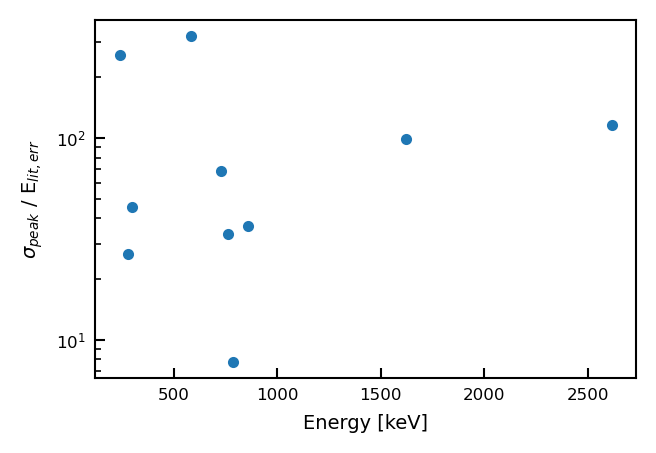

In [87]:
plt.errorbar(df_calibration.e_lit, ratio_width_fitlit, 
            fmt = 'o', ms = 3)
#plt.axhline(y = 20, color = 'gray')
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('$\sigma_{peak}$ / E$_{lit, err}$')
plt.show()

In [88]:
## Remove lines where ratio_width_fitlit<20
#reconstr_e = reconstr_e[ratio_width_fitlit>20]
#reconstr_e_err = reconstr_e_err[ratio_width_fitlit>20]

In [89]:
rel_resol = cal_CE_a*df_calibration.peak_width / reconstr_e
rel_resol_err = rel_resol*np.sqrt((reconstr_e_err/reconstr_e)**2+(cal_CE_a_err/cal_CE_a)**2+(df_calibration.peak_width_unc/df_calibration.peak_width)**2)

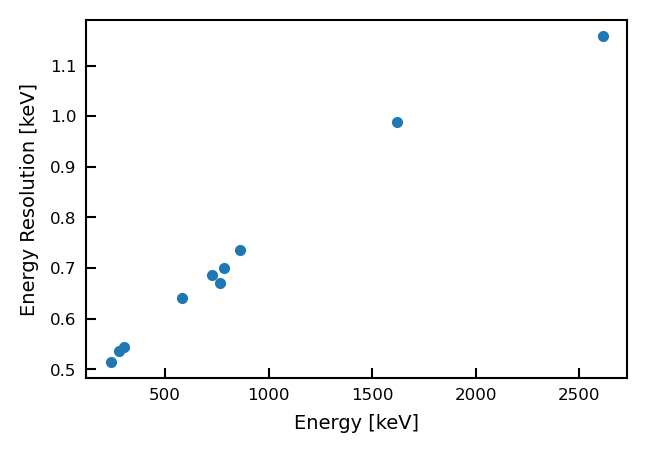

In [90]:
plt.errorbar(df_calibration.e_lit, rel_resol*reconstr_e, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3)
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [keV]')
plt.show()

In [91]:
def relresolFunc(E, a,b,c):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

In [92]:
popt_relresol, pcov_relresol = curve_fit(relresolFunc, df_calibration.e_lit, rel_resol, 
                       p0=[0.1, 0.1, 0.1], 
                       bounds=((0, 0, 0),
                               (+np.inf, +np.inf, +np.inf)), 
                       sigma=rel_resol_err, maxfev=10000)
print(popt_relresol[0])
print(popt_relresol[1])
print(popt_relresol[2])
print(np.sqrt(np.diag(pcov_relresol)))
reconstr_relresol = relresolFunc(df_calibration.e_lit, *popt_relresol)
residuals = reconstr_relresol - rel_resol
reconstr_relresol_err = 1/2*np.sqrt(popt_relresol[0]**2/df_calibration.e_lit**4 + popt_relresol[1]**2/df_calibration.e_lit**2 + popt_relresol[2]**2)
residuals_err = np.sqrt(reconstr_relresol_err**2 + rel_resol_err**2)
chi2 = np.sum(residuals**2 / residuals_err**2)
dof = len(residuals)-len(popt)

0.16570982341631407
0.0004146828719208912
1.449476177496252e-08
[5.02361269e-03 1.65026152e-05 7.45251069e-09]


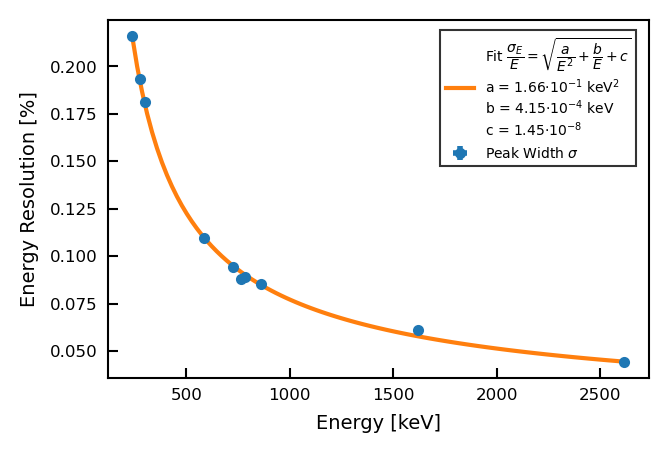

In [93]:
plt.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt_relresol[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt_relresol[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$')
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit.png', bbox_inches='tight')
plt.show()

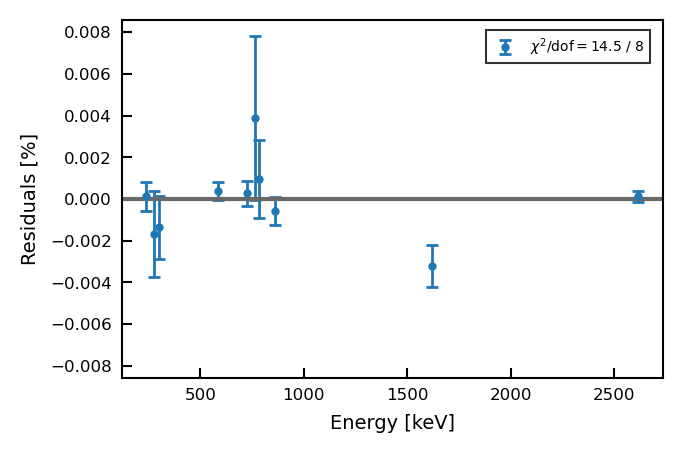

In [94]:
plt.errorbar(df_calibration.e_lit, 100*residuals, yerr = 100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals), color = 'dimgray')
plt.xlabel('Energy [keV]')
plt.ylabel('Residuals [%]')
val_lim = max(np.abs(100*1.1*np.max(residuals+residuals_err)), np.abs(100*1.1*np.min(residuals-residuals_err)))
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals.png', bbox_inches='tight')
plt.show()

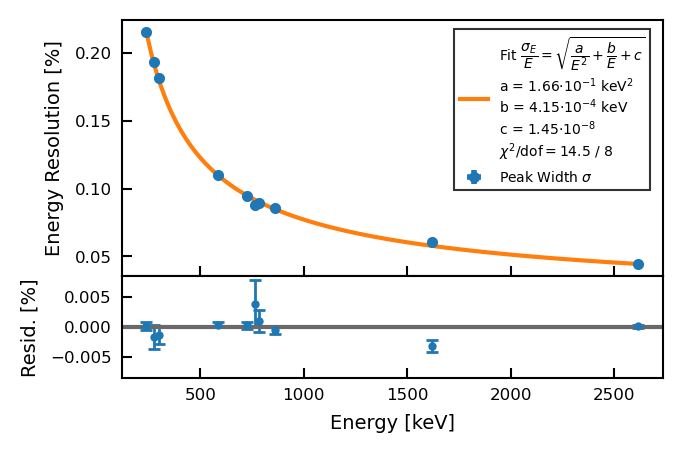

In [95]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt_relresol[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt_relresol[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, 100*residuals, yerr = 100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(100*1.1*np.max(residuals+residuals_err)), np.abs(100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals.png', bbox_inches='tight')
plt.show()

### as function of MCA

In [96]:
resol = df_calibration.peak_width
resol_err = df_calibration.peak_width_unc

In [97]:
def resolFunc(E, a,b,c):
    resol = np.sqrt(a*(E**2) + b*E + c)
    return resol

In [98]:
popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2

(1.449476177496252e-08, 0.0025300992006176116, 6.168664607090315)

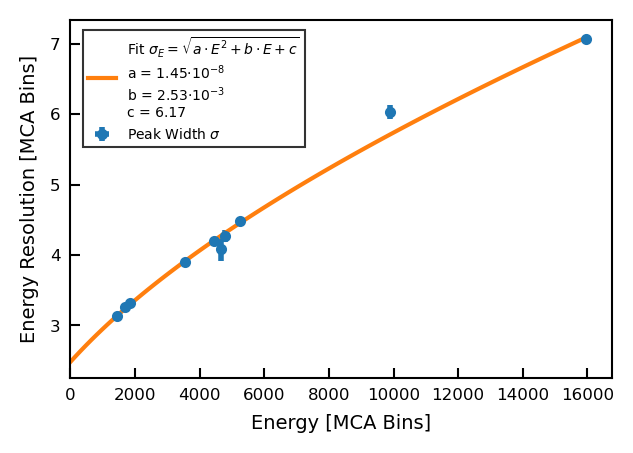

In [99]:
plt.errorbar(df_calibration.peak_position, resol, yerr = resol_err, xerr = df_calibration.peak_position_unc,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = np.linspace(0, np.array(df_calibration.peak_position)[-1], 100)
plt.plot(x_val, resolFunc(x_val, popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2), 
         label = 'Fit $\sigma_E = \sqrt{a \cdot E^2 + b \cdot E +c}$'
         +'\na = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$' 
         +'\nb = '+str(round(1e3*popt_relresol[1]/cal_CE_a,2))+'$\cdot 10^{-3}$' 
         +'\nc = '+str(round(1e0*popt_relresol[0]/cal_CE_a**2,2)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [MCA Bins]')
plt.ylabel('Energy Resolution [MCA Bins]')
plt.xlim(left = 0)
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_ADC.png', bbox_inches='tight')
plt.show()

In [100]:
residuals_conv = residuals*df_calibration.e_lit
residuals_err_conv = residuals_err*df_calibration.e_lit

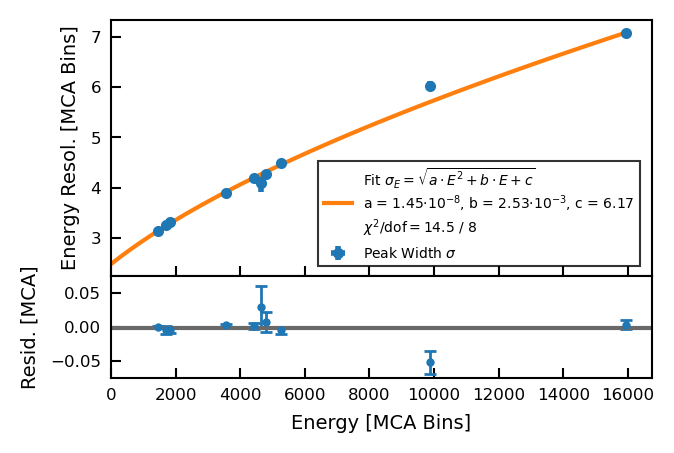

In [101]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, resol, yerr = resol_err, xerr = df_calibration.peak_position_unc,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = x_val = np.linspace(0, np.array(df_calibration.peak_position)[-1], 100)
ax0.plot(x_val, resolFunc(x_val, popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2), 
         label = 'Fit $\sigma_E = \sqrt{a \cdot E^2 + b \cdot E +c}$'
         +'\na = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$' 
         +', b = '+str(round(1e3*popt_relresol[1]/cal_CE_a,2))+'$\cdot 10^{-3}$' 
         +', c = '+str(round(1e0*popt_relresol[0]/cal_CE_a**2,2))
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resol. [MCA Bins]')
ax0.set_xlim(left = 0)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_conv, yerr = residuals_err_conv,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_conv), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [MCA Bins]')
ax1.set_ylabel('Resid. [MCA]')
val_lim = max(np.abs(1.1*np.max(residuals_conv+residuals_err_conv)), np.abs(1.1*np.min(residuals_conv-residuals_err_conv)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_xlim(left = 0)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=4, bbox_to_anchor=(0.99,0.01), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals_adc.png', bbox_inches='tight')
plt.show()

In [102]:
print('MCA_ch Resolution MCA_ch_error Resolution_error')
out = np.array([np.array(df_calibration.peak_position), np.array(resol), 
                np.array(df_calibration.peak_width), np.array(resol_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Resolution MCA_ch_error Resolution_error
1452.9906683702668 3.141509558576204 3.141509558576204 0.009760711124288553
1689.357801248906 3.267483615801284 3.267483615801284 0.03472859901907712
1828.229959425114 3.319151096928983 3.319151096928983 0.02781032540461692
3555.394139289011 3.905219921789919 3.905219921789919 0.015753456466240164
4434.746474052303 4.193013714145492 4.193013714145492 0.026755232963070738
4654.664610164821 4.092632440409798 4.092632440409798 0.182970658723114
4789.8259335575285 4.270845735485948 4.270845735485948 0.08947321023545221
5247.610566902027 4.486178674626028 4.486178674626028 0.034345203656941756
9885.515835437665 6.027344607841198 6.027344607841198 0.10109153259399817
15948.970765308659 7.0670317574363155 7.0670317574363155 0.04051398650388441


In [103]:
print('MCA_ch Residual MCA_ch_error Residual_error')
out = np.array([np.array(df_calibration.peak_position), np.array(residuals_conv), 
                np.array(df_calibration.peak_width), np.array(residuals_err_conv)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Residual MCA_ch_error Residual_error
1452.9906683702668 0.00031750038707921077 3.141509558576204 0.0016512085215947484
1689.357801248906 -0.00468733710212028 3.267483615801284 0.005704242385909098
1828.229959425114 -0.004100711678378989 3.319151096928983 0.004571071104633104
3555.394139289011 0.002185672279822842 3.905219921789919 0.002594377613412553
4434.746474052303 0.00194956590513998 4.193013714145492 0.00439174748518916
4654.664610164821 0.029675994835593713 4.092632440409798 0.029993196606300208
4789.8259335575285 0.0074793190722279804 4.270845735485948 0.01466379777491034
5247.610566902027 -0.005002012003581477 4.486178674626028 0.005633808366469151
9885.515835437665 -0.05202166639922156 6.027344607841198 0.01657073133535562
15948.970765308659 0.0031667618040022412 7.0670317574363155 0.00664385739086598


## Resolution FWHM

In [104]:
sigma_to_fwhm = 2*np.sqrt(2*np.log(2))
print('factor Gaussian sigma to FWHM: '+str(sigma_to_fwhm))

factor Gaussian sigma to FWHM: 2.3548200450309493


In [105]:
popt_relresol_fwhm = popt_relresol*sigma_to_fwhm**2
popt_relresol_fwhm

array([9.18890375e-01, 2.29949011e-03, 8.03760261e-08])

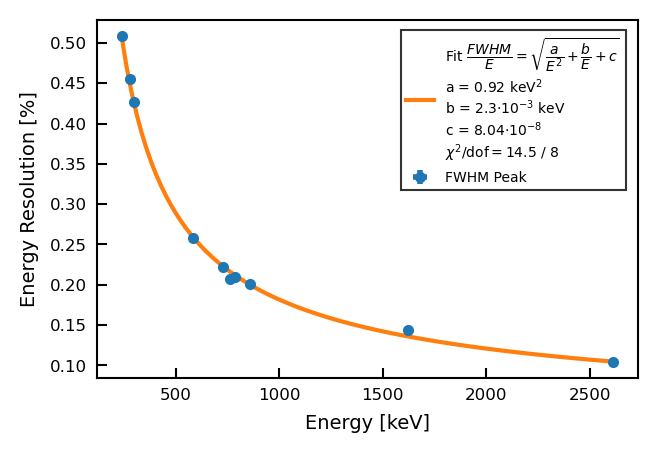

In [106]:
plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)

plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit.png', bbox_inches='tight')
plt.show()

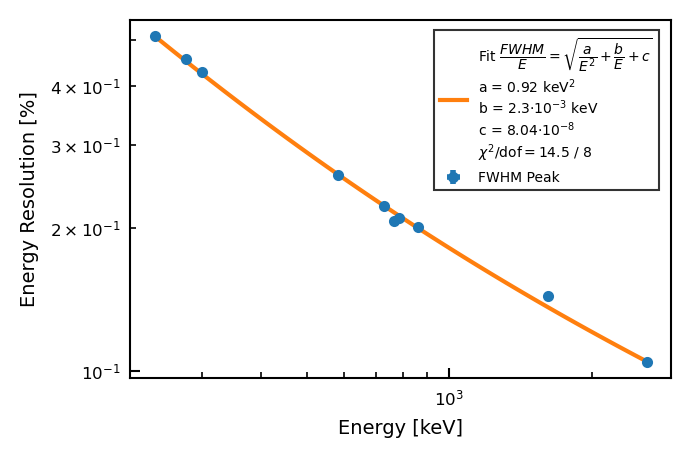

In [107]:
plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_loglog.png', bbox_inches='tight')
plt.show()

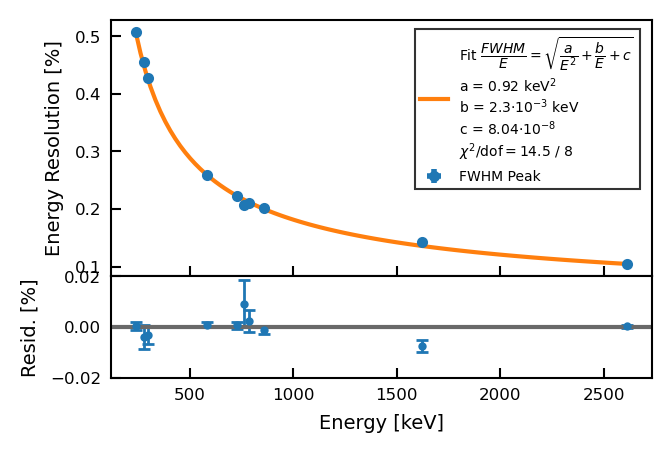

In [108]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*residuals, yerr = sigma_to_fwhm*100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(sigma_to_fwhm*100*1.1*np.max(residuals+residuals_err)), np.abs(sigma_to_fwhm*100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_residuals.png', bbox_inches='tight')
plt.show()

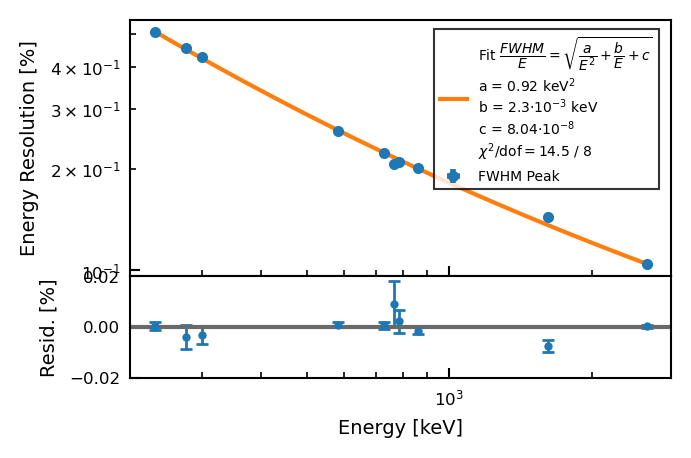

In [109]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')
ax0.set_xscale('log'); ax0.set_yscale('log');

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*residuals, yerr = sigma_to_fwhm*100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(sigma_to_fwhm*100*1.1*np.max(residuals+residuals_err)), np.abs(sigma_to_fwhm*100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)
ax1.set_xscale('log'); 

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_residuals_loglog.png', bbox_inches='tight')
plt.show()

In [110]:
'''matplotlib.rcParams['figure.figsize'] = (3.4908516673585166/1.2, 2.327234444905678)

plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_aspectratio.png', bbox_inches='tight')
plt.show()''';

# Other Stuff

In [111]:
print(cal_CE)
print(cal_EC)

(0.16389984701772356, 0.46454797148251575)
(6.101286963933917, -2.8343404825282184)


In [112]:
linFunc(np.array([100, 2700]), *cal_EC)

array([  607.29435591, 16470.64046214])

In [113]:
linFunc(np.array([0, 16383]), *cal_CE)

array([4.64547971e-01, 2.68563574e+03])

In [114]:
Energy_check = 1332.49
Energy_check*relresolFunc(Energy_check, *popt_relresol_fwhm)

2.031169112243768

In [115]:
cal_202105_CE_a = 0.16480422280063092
cal_202105_CE_b = 0.49977182490554006
cal_202105_CE = (cal_202105_CE_a, cal_202105_CE_b)
cal_202105_EC_a = 1/cal_202105_CE_a
cal_202105_EC_b = -cal_202105_CE_b/cal_202105_CE_a
cal_202105_EC = (cal_202105_EC_a, cal_202105_EC_b)

def func_e_to_adc(x = np.array([100, 2700]), a = cal_202105_EC_a, b = cal_202105_EC_b):
    res = a*x+b
    return res
def func_adc_to_e(x = np.array([0, 16383]), a = cal_202105_CE_a, b = cal_202105_CE_b):
    res = a*x+b
    return res

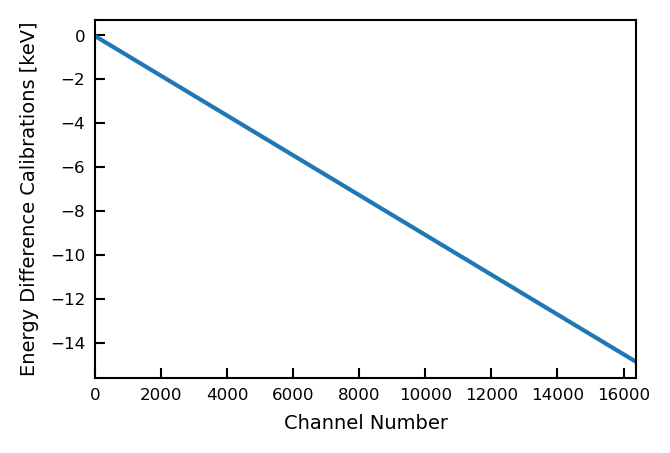

In [116]:
x_list = np.linspace(0,16383,10)
plt.plot(x_list, linFunc(x_list, *popt) - func_adc_to_e(x_list))
plt.xlim(0,16383)
plt.xlabel('Channel Number')
plt.ylabel('Energy Difference Calibrations [keV]')
if save_plots:
    plt.savefig(filename_suffix_save+'_diff_to_calib202105.png', bbox_inches='tight')
plt.show()

In [117]:
p_resol_202105 = (8.97573110e-01, 2.29320769e-03, 1.52084498e-26)

def relresolFunc_old(E, a=p_resol_202105[0], b=p_resol_202105[1], c=p_resol_202105[2]):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

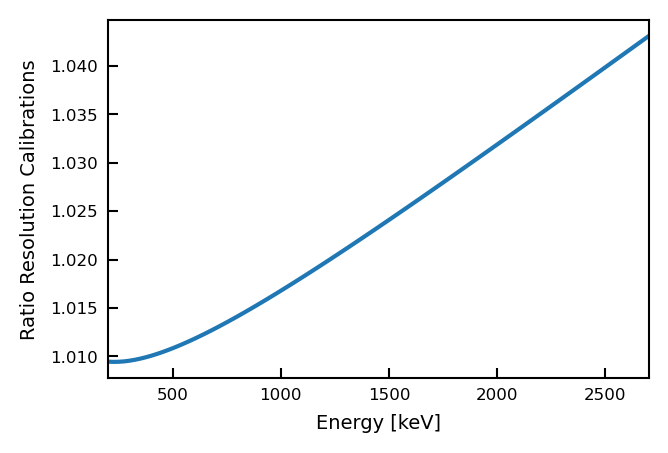

In [118]:
x_list = np.linspace(200,2700,100)

plt.plot(x_list, relresolFunc(x_list, *popt_relresol_fwhm) / relresolFunc_old(x_list))
plt.xlim(200,2700)
plt.xlabel('Energy [keV]')
plt.ylabel('Ratio Resolution Calibrations')
if save_plots:
    plt.savefig(filename_suffix_save+'_ratioresol_to_calib202105.png', bbox_inches='tight')
plt.show()